In [1]:
# Table/Data Manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

# Plotting
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Hyperparameter Search and Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Modeling
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Feature importance comparison using SHAP
import shap

/opt/anaconda3/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Loading in the House Prices Dataset

In [4]:
# Dataset available at
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# putting everything together for handling missing data, idx and target removed
house = pd.concat([train.iloc[:, range(1,80)], test.iloc[:, range(1,80)]]) 
house = house.reset_index(drop=True)

In [6]:
# Printing the sizes of the tables

print("Train set size: ", train.shape)
print("Test set size: ", test.shape)
print("Overall set size: ", house.shape)

Train set size:  (1460, 81)
Test set size:  (1459, 80)
Overall set size:  (2919, 79)


In [8]:
# Number of missing values

np.sum(house.isna().sum())

15707

<BarContainer object of 34 artists>

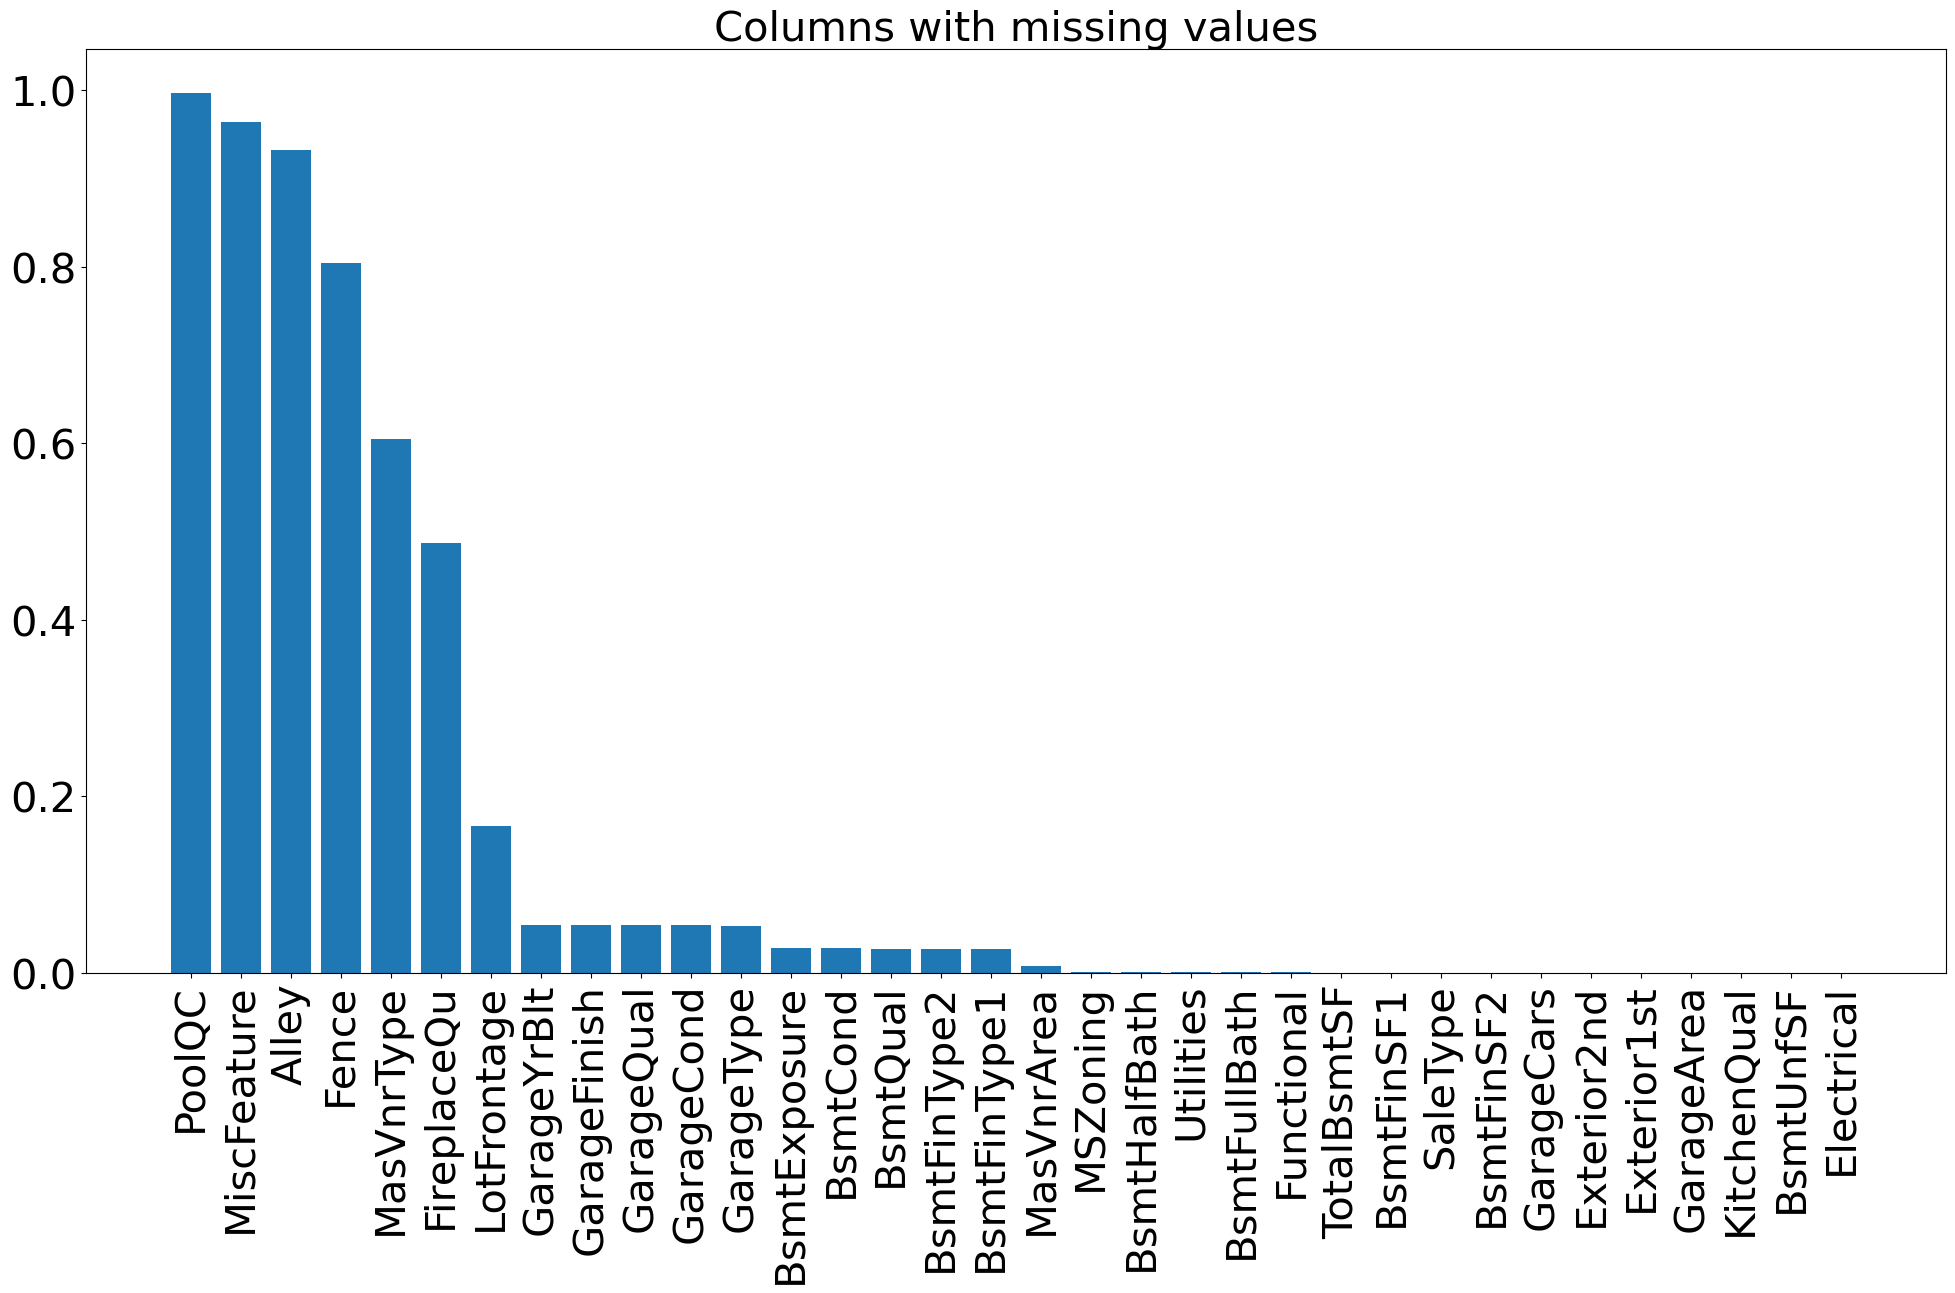

In [10]:
# get columns with missing and sort
missings = house.isna().sum()/2919
missings = missings.sort_values(ascending=False)
# remove 0s
missings = missings[missings != 0]

# plot
plt.figure(figsize=(24,12))
plt.title("Columns with missing values", fontsize=30)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.bar(missings.index, missings)

## Missing Data

In [13]:
# It is important to note that a lot of "missing" values actually represent something
# in this dataset... After going through the documentation, the following variables
# have meaningful NA

special_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", \
                "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", \
                "PoolQC", "Fence", "MiscFeature", "MasVnrType"]

# Fill them with special "None" category

for special_col in special_cols:
    house[special_col] = house[special_col].fillna("None")

house["MasVnrArea"] = house["MasVnrArea"].fillna(0)

# 2207 is not valid year. Looking at this row, 2007 makes sense

house.loc[2592, "GarageYrBlt"] = 2007

# MSSubClass is actually categorical, not an int

house["MSSubClass"] = house["MSSubClass"].astype("category")
house["MoSold"] = house["MoSold"].astype("category")

# impute missing garageyrblt with mean

# house = house.drop(["GarageYrBlt"],axis=1)

house["GarageYrBlt"] = house["GarageYrBlt"].fillna(np.mean(house["GarageYrBlt"]))

# Again. no garage

house["GarageCars"] = house["GarageCars"].fillna(0)
house["GarageArea"] = house["GarageArea"].fillna(0)

# No basement

house["BsmtFinSF1"] = house["BsmtFinSF1"].fillna(0)
house["BsmtFinSF2"] = house["BsmtFinSF2"].fillna(0)
house["BsmtUnfSF"] = house["BsmtUnfSF"].fillna(0)
house["TotalBsmtSF"] = house["TotalBsmtSF"].fillna(0)
house["BsmtFullBath"] = house["BsmtFullBath"].fillna(0)
house["BsmtHalfBath"] = house["BsmtHalfBath"].fillna(0)

# Removing MiscVal

house = house.drop(["MiscVal"],axis=1)

<BarContainer object of 9 artists>

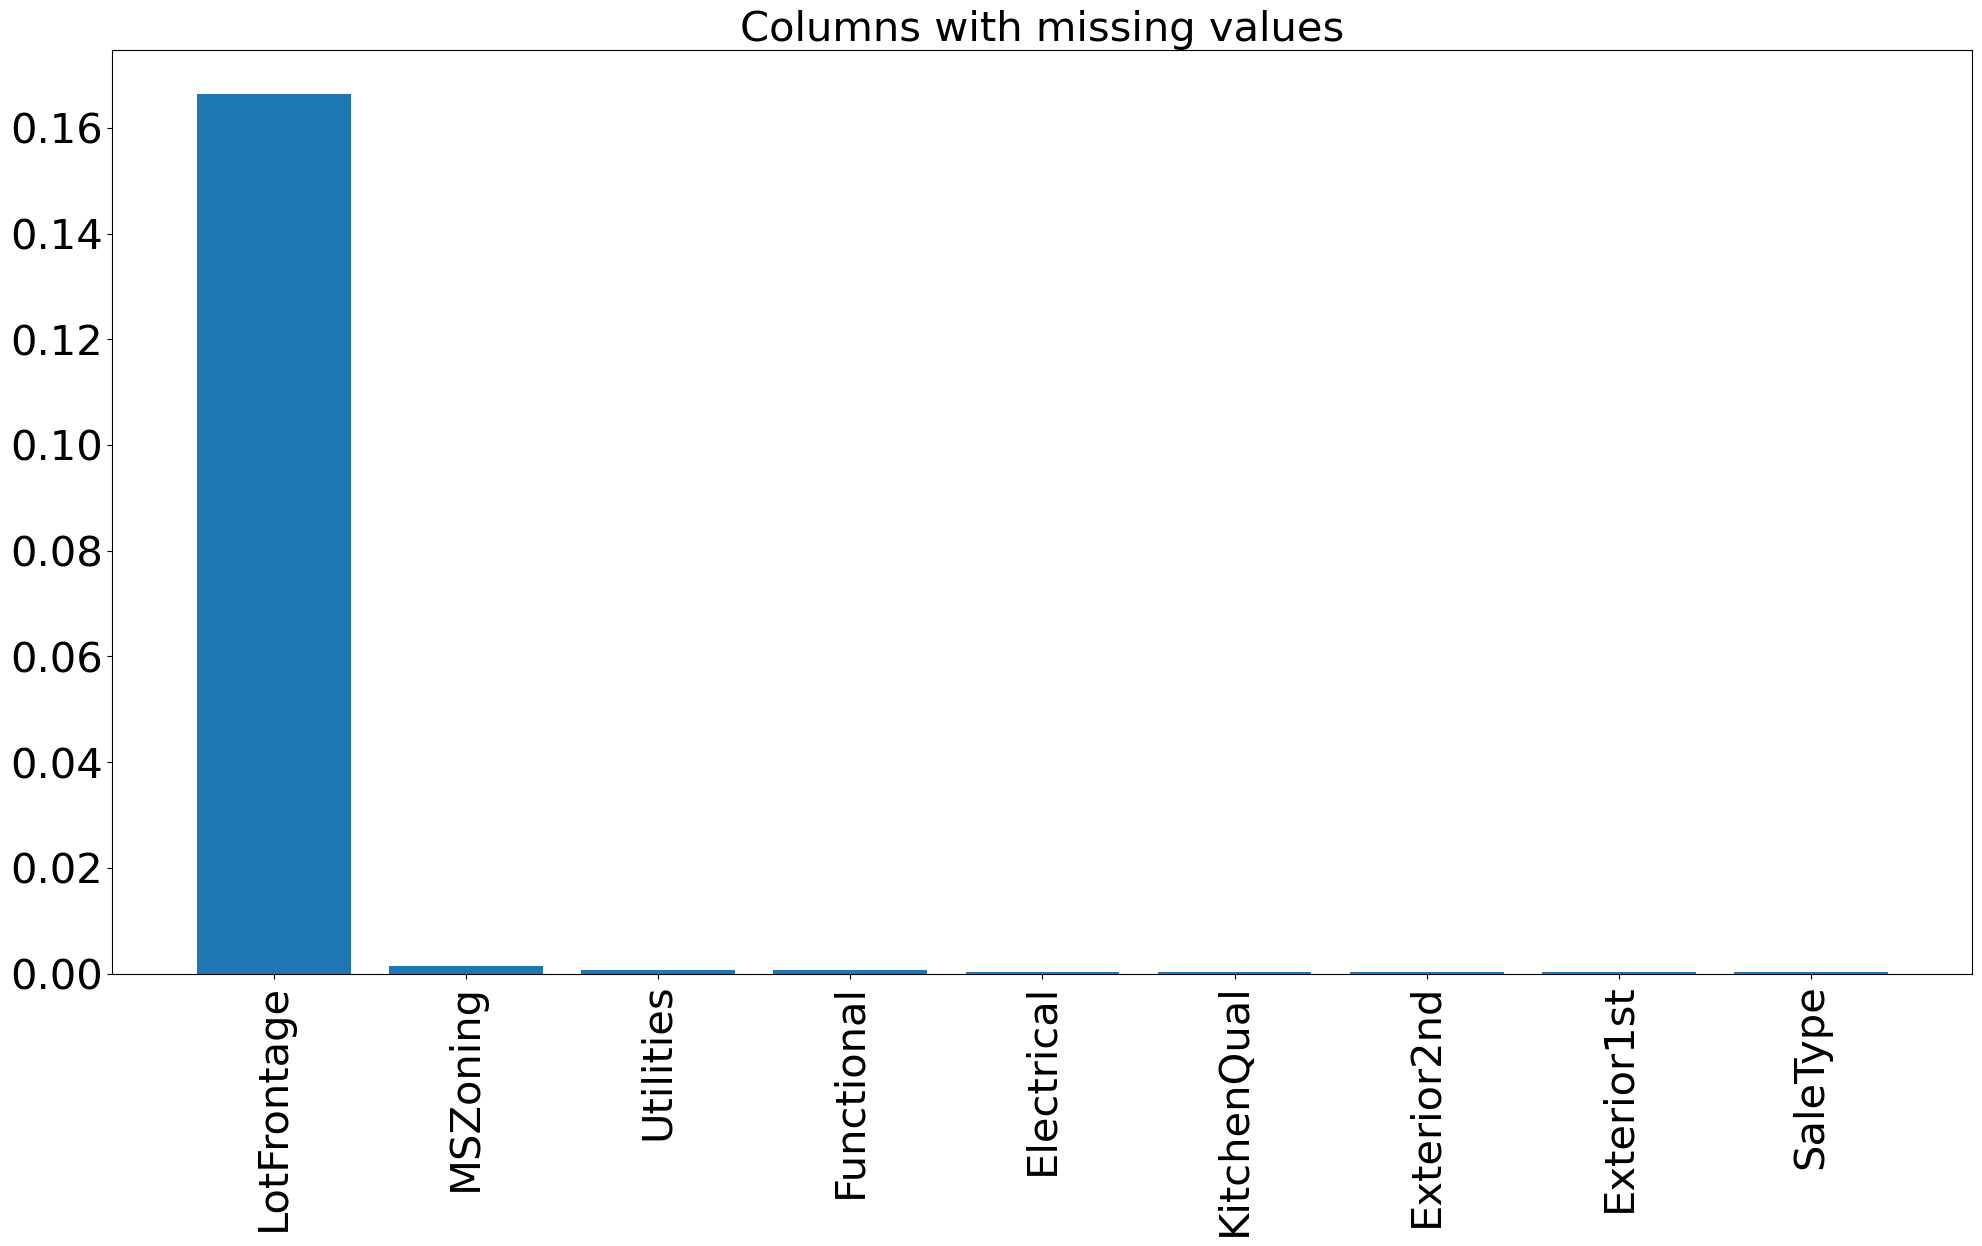

In [15]:
# now that meaningful mising values are filled, let's plot again

# get columns with missing and sort
missings = house.isna().sum()/2919
missings = missings.sort_values(ascending=False)
# remove 0s
missings = missings[missings != 0]

# plot
plt.figure(figsize=(24,12))
plt.title("Columns with missing values", fontsize=30)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.bar(missings.index, missings)

In [17]:
# Get the names of the rest of the missing columns
missing_cols = house.columns[house.isna().sum()>0]

In [19]:
# Categorical Columns:
for col in missing_cols:
   if not pd.api.types.is_numeric_dtype(house[col]):
        house.loc[house[col].isna(), col] = house[col].mode()[0]

In [21]:
# All that is left is to predict LotFrontage

# standardizing for knn
scaler = preprocessing.StandardScaler()

# dummy encode
house_dummies = pd.get_dummies(house)

# rows with nothing missing
house_no_na = house_dummies[np.invert(house.isna().any(axis=1))]
# rows with missing lot frontage
house_na = house_dummies[house.isna().any(axis=1)]

# train X
notfrontage_train = scaler.fit_transform(np.asarray(house_no_na.drop(["LotFrontage"],axis=1)))
# train y
frontage_train = np.asarray(house_no_na["LotFrontage"])
# test x
notfrontage_test = scaler.fit_transform(np.asarray(house_na.drop(["LotFrontage"],axis=1)))

# # knn k=1 and predict on the closest home
knn_model = KNeighborsRegressor(n_neighbors=1).fit(notfrontage_train, frontage_train)
frontage_pred = knn_model.predict(notfrontage_test)

# # replace na with predictions
house.loc[house["LotFrontage"].isna(), "LotFrontage"] = frontage_pred

In [23]:
# calculate the number of missing values left in the data

np.sum(house.isna().sum())

0

## Ordinal Encoding
The following section is simply encoding variables that appear ordinal as a numerical rating.

In [26]:
# Categorical Variables:

#### Ordinal (need to know for ordinal encoding) ###################

# LotShape - 0,1,2,3 : IR3,IR2,IR1,Reg
mp = {"IR3":0,"IR2":1,"IR1":2,"Reg":3}
house["LotShape"] = house["LotShape"].map(mp)

# LandSlope - 0,1,2 : Gtl,Mod,Sev
mp = {"Gtl":0,"Mod":1,"Sev":2}
house["LandSlope"] = house["LandSlope"].map(mp)

# ExterQual - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["ExterQual"] = house["ExterQual"].map(mp)

# ExterCond - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["ExterCond"] = house["ExterCond"].map(mp)

# BsmtQual - 0,1,2,3,4,5 : None,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["BsmtQual"] = house["BsmtQual"].map(mp)

# BsmtCond - 0,1,2,3,4,5 : None,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["BsmtCond"] = house["BsmtCond"].map(mp)

# BsmtFinType1 - 0,1,2,3,4,5,6 : None,Unf,LwQ,Rec,BLQ,ALQ,GLQ
mp = {"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}
house["BsmtFinType1"] = house["BsmtFinType1"].map(mp)

# BsmtExposure - 0,1,2,3,4,5 : None,Po,No,Mn,Av,Gd
mp = {"None":0,"Po":1,"No":2,"Mn":3,"Av":4,"Gd":5}
house["BsmtExposure"] = house["BsmtExposure"].map(mp)

# HeatingQC - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["HeatingQC"] = house["HeatingQC"].map(mp)

# KitchenQual - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["KitchenQual"] = house["KitchenQual"].map(mp)

# FireplaceQu - 0,1,2,3,4,5 : NA,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["FireplaceQu"] = house["FireplaceQu"].map(mp)

# GarageFinish - 0,1,2,3 : NA,Unf,RFn,Fin
mp = {"None":0,"Unf":1,"RFn":2,"Fin":3}
house["GarageFinish"] = house["GarageFinish"].map(mp)

# GarageQual - 0,1,2,3,4,5 : NA,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["GarageQual"] = house["GarageQual"].map(mp)

# GarageCond - 0,1,2,3,4,5 : NA,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["GarageCond"] = house["GarageCond"].map(mp)

# PoolQC - 0,1,2,3,4 : NA,Fa,TA,Gd,Ex
mp = {"None":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["PoolQC"] = house["PoolQC"].map(mp)


In [28]:
# Save data at this point for plotting later
D = house.loc[np.arange(0,train.shape[0],1),]
D["SalePrice"] = train["SalePrice"]

## Treatment Encoding

Now that we have seen some of the relationships between the predictors and the SalePrice, its time to finish this analysis by preparing the data for a future model.

In [31]:
#### Nominal (need to know for treatment encoding) ######################

# MSZoning,Street,Alley,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,
# RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtFinType1,BsmtFinType2,Heating,CentralAir,
# Electrical,Functional,GrarageType,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition

house = pd.get_dummies(house, drop_first=True)

## Standardization

Although decision tree methods may not require it, standardizing the features may be useful for other types of models.

In [34]:
# #### Center and Scale all attributes ################################

# this will change the form of the treatment encoding, but the gist is the same.

house = pd.DataFrame(scaler.fit_transform(house), columns=house.columns)

In [36]:
# First n1 rows are still the training data
train_filled = house.loc[np.arange(0,train.shape[0],1),]
train_filled["SalePrice"] = train["SalePrice"]
# last n2 rows are still the testing data
test_filled = house.loc[train.shape[0]:,]
test_filled = test_filled.reset_index(drop=True)

## Exploratory Data Analysis


In [39]:
# X, y represent the training features and log-target
# I have truth as a flattened y for simplicity later
X = np.asarray(train_filled.drop(["SalePrice"],axis=1))
y = np.vstack(np.log(np.asarray(train_filled["SalePrice"])))
truth = y.flatten()

In [41]:
# Hyperparameters arbitrarily chosen
eda_model = XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.06)

# Fit the model
eda_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='weight', ylabel='Features'>

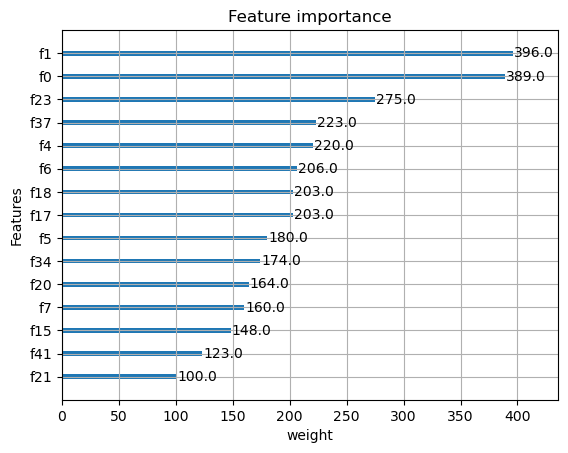

In [43]:
# Plot importance scores
plot_importance(eda_model, max_num_features=15, importance_type="weight", xlabel="weight")

In [45]:
# Get col indices from plot
col_idx = [1,0,23,37,4,6,18,17,5,34,20,7,15,41,21]

# Print list of col names in order of weight
list(train_filled.columns[col_idx])

['LotArea',
 'LotFrontage',
 'GrLivArea',
 'GarageArea',
 'OverallQual',
 'YearBuilt',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'OverallCond',
 'GarageYrBlt',
 '1stFlrSF',
 'YearRemodAdd',
 'BsmtFinSF1',
 'OpenPorchSF',
 '2ndFlrSF']

In [47]:
# Create hyperparameter grid for xgboost
xgb_grid = {"n_estimators": np.arange(900,1500,50),
            "max_depth": np.arange(2,5,1),
            "learning_rate": np.arange(0.02,0.11,0.04),
            "colsample_bytree": np.arange(0.02,0.12,0.02)}

# initialize model
xgb = XGBRegressor()

# fit the grid search
xgb_cv = GridSearchCV(xgb, xgb_grid, cv=8)
xgb_cv.fit(X,y)

# Print the best estimator
print(xgb_cv.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
